# Scikit learn, supervised learning, part 1

In [50]:
import numpy as np
import scipy
import sklearn

import matplotlib.pyplot as plt

%matplotlib inline

In [51]:
mnist = np.loadtxt("../data/mnist_train.csv", delimiter=",", skiprows=1)

In [52]:
X = mnist[:10000, 1:]
y = mnist[:10000, 0]

print X.shape

(10000, 784)


In [53]:
def plot_roc_auc(y_score, y_test):
    from sklearn.metrics import roc_curve, auc
    # Compute micro-average ROC curve and ROC area
    fpr = dict()
    tpr = dict()
    roc_auc = dict()

    for i in range(10):
        fpr[i], tpr[i] , _ = roc_curve(np.where(y_test == i, 1, 0).ravel(), y_score[:, i].ravel())
        roc_auc[i] = auc(fpr[i], tpr[i])


    ##############################################################################
    # Plot of a ROC curve for a specific class
    plt.figure(num=None, figsize=(14, 7), dpi=400)
    for i in range(10):
        plt.plot(fpr[i], tpr[i], label='ROC curve for %d (area = %0.2f)' % (i, roc_auc[i]))

    plt.plot([0, 1], [0, 1], 'k--')
    plt.xlim([0.0, 1.0])
    plt.ylim([0.0, 1.05])
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.title('Receiver operating characteristic example')
    plt.legend(loc="lower right")
    return plt.show()

## Some utilities

In [54]:
from sklearn.cross_validation import train_test_split

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.25, random_state=333)

In [55]:
from sklearn.metrics import auc, accuracy_score

## Naive Bayes

In [56]:
from sklearn.naive_bayes import GaussianNB

gnb = GaussianNB()

In [57]:
%%time

gnb.fit(X_train, y_train)
y_predicted = gnb.predict(X_test)

CPU times: user 187 ms, sys: 23.3 ms, total: 211 ms
Wall time: 210 ms


In [58]:
accuracy_score(y_predicted, y_test)

0.5444

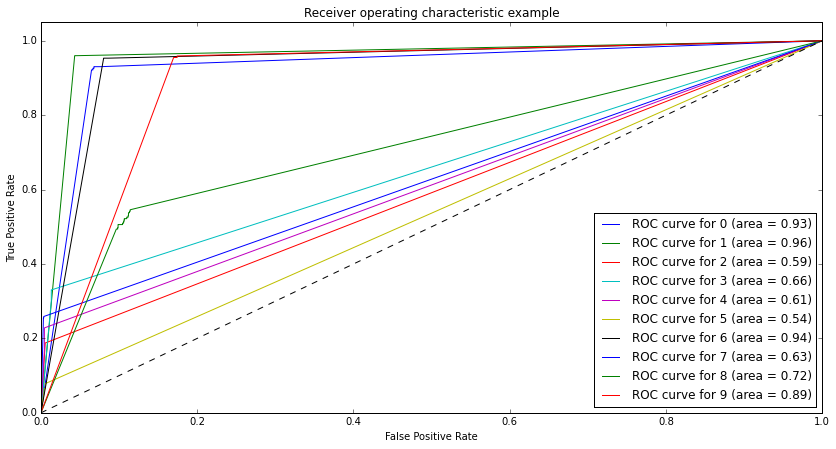

In [59]:
y_score = gnb.predict_proba(X_test)

plot_roc_auc(y_score, y_test)

Note how NB is making prediction only in {0, 1}. Why does that happen?

## kNN

In [60]:
from sklearn.neighbors import KNeighborsClassifier

In [61]:
%%time

knn = KNeighborsClassifier(n_neighbors=5).fit(X_train, y_train)
y_predicted = knn.predict_proba(X_test)

CPU times: user 19.2 s, sys: 477 µs, total: 19.2 s
Wall time: 19.2 s


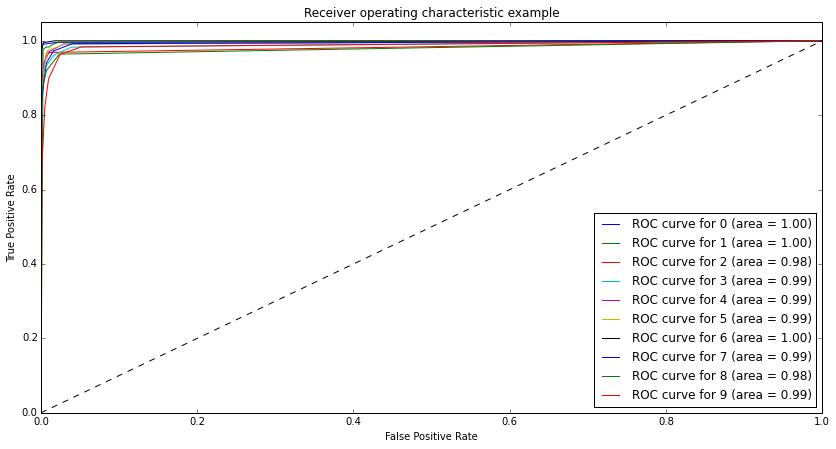

In [62]:
plot_roc_auc(y_predicted, y_test)

In [63]:
y_predicted = knn.predict(X_test)

In [64]:
accuracy_score(y_predicted, y_test)

0.94799999999999995

### Searching for optimal k

In [135]:
X_train_, X_validation, y_train_, y_validation = train_test_split(X_train, y_train, test_size=0.8)

ks = np.arange(1, 10)
acc = np.zeros(ks.shape)

for i in range(ks.shape[0]):
    y_predicted = KNeighborsClassifier(n_neighbors=ks[i]).fit(X_train_, y_train_).predict(X_validation)
    acc[i] = accuracy_score(y_predicted, y_validation)

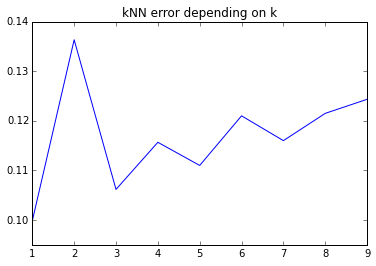

In [136]:
plt.plot(ks, 1.0 - acc)
plt.title("kNN error depending on k")

### Nearest Neighbor algoritms

- KDTree
- BallTree
- brute force

## Metrics

Possible metrics are closely related to Nearest Neghbor algorithms, for tree-like algorithms it should satisfy triangle inequality:
$$|x + y| \leq |x| + |y|$$

## Regression

In [67]:
N = 20
xs = np.linspace(0, 1, num=N).reshape((N, 1))

In [68]:
ys = xs * 0.75 + np.random.standard_normal(size=N).reshape((N, 1)) * 0.1

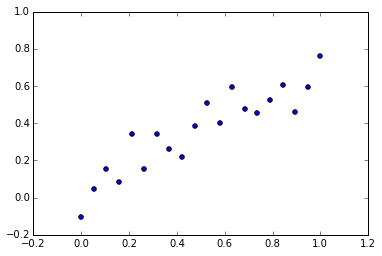

In [69]:
plt.scatter(xs, ys)

### Ordinary Least Squares

In [70]:
from sklearn.linear_model import LinearRegression

In [71]:
lsr = LinearRegression().fit(xs, ys)

In [72]:
lsr.coef_

array([[ 0.64247415]])

In [73]:
test_xs = np.linspace(0, 1.0, num=100).reshape((100, 1))
test_ys = lsr.predict(test_xs)

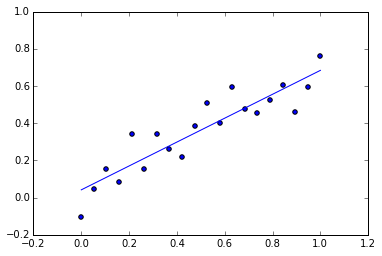

In [74]:
plt.scatter(xs, ys)
plt.plot(test_xs, test_ys)

### Ridge regression

In [75]:
import scipy.special

xs = np.linspace(0, 1, 50)
signal = scipy.special.jv(0.0, xs * 20)
ys = signal + np.random.standard_normal(size=xs.shape[0]) * 0.1

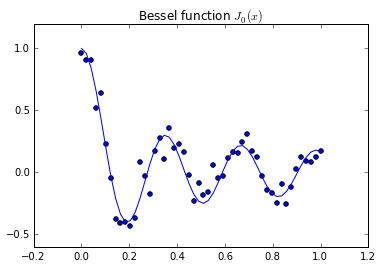

In [76]:
plt.scatter(xs, ys)
plt.plot(xs, signal)
plt.title("Bessel function $J_0(x)$")

In [77]:
def make_cosine_basis(xs, k = 5):
    js = np.arange(k)
    A = np.cos(np.outer(xs, js))
    return A

In [78]:
k = 30

X = make_cosine_basis(xs, k = k)
xs_test = np.linspace(0, 1, num=100)

X_test = make_cosine_basis(xs_test, k = k)

In [79]:
from sklearn.linear_model import LinearRegression

lsr = LinearRegression(fit_intercept=False).fit(X, ys)

In [80]:
ys_lsr = lsr.predict(X_test)

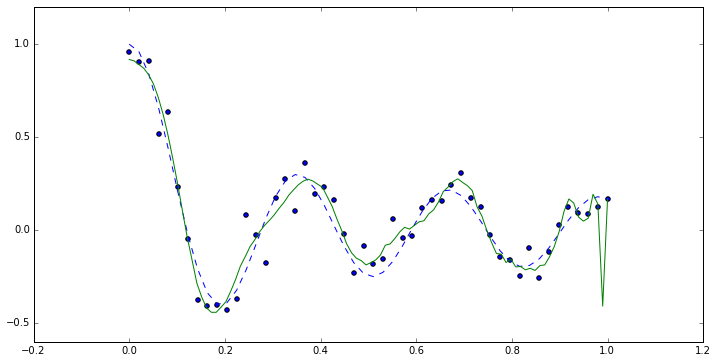

In [81]:
plt.figure(None, figsize=(12, 6))
plt.plot(xs, signal, "--")
plt.scatter(xs, ys)
plt.plot(xs_test, ys_lsr)

In [82]:
from sklearn.linear_model import Ridge

alphas = np.linspace(0, 2, num=5)
ridge = [Ridge(alpha=alpha, fit_intercept=False).fit(X, ys) for alpha in alphas]

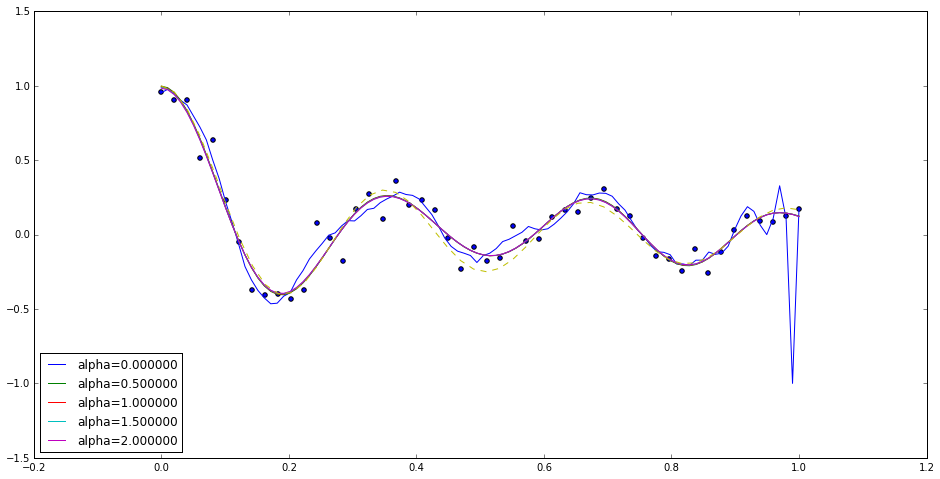

In [83]:
test_ys = [ reg.predict(X_test) for reg in ridge ]

plt.figure(figsize=(16, 8))

for test_y, alpha in zip(test_ys, alphas):
    plt.plot(xs_test, test_y, label="alpha=%f" % alpha)
    
plt.scatter(xs, ys)
plt.plot(xs, signal, "--")
plt.legend(loc="lower left")

### LASSO

In [84]:
from sklearn.linear_model import Lasso

alphas = np.linspace(0.001, 0.02, num=5)
ridge = [Lasso(alpha=alpha, fit_intercept=False).fit(X, ys) for alpha in alphas]

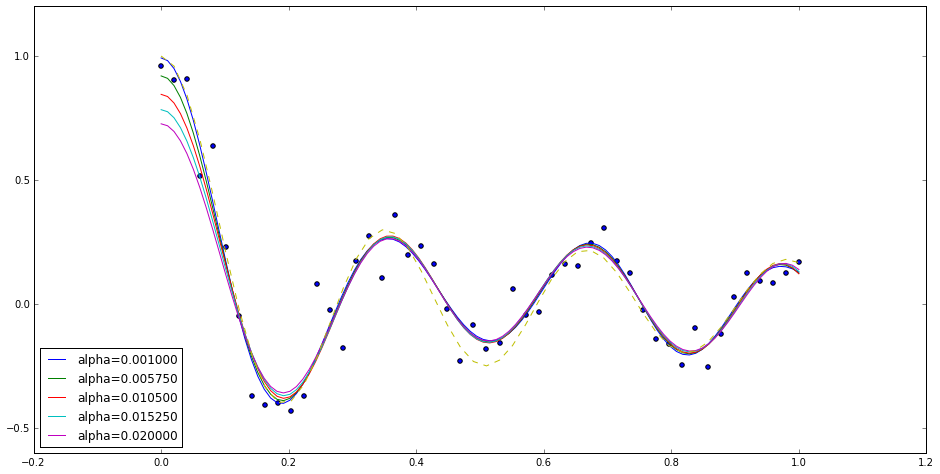

In [85]:
test_ys = [ reg.predict(X_test) for reg in ridge ]

plt.figure(figsize=(16, 8))

for test_y, alpha in zip(test_ys, alphas):
    plt.plot(xs_test, test_y, label="alpha=%f" % alpha)
    
plt.scatter(xs, ys)
plt.plot(xs, signal, "--")
plt.legend(loc="lower left")

### Elastic Net

In [86]:
from sklearn.linear_model import ElasticNet

alpha = 0.05

en = ElasticNet(alpha=alpha, fit_intercept=False).fit(X, ys)
ridge = Ridge(alpha=alpha, fit_intercept=False).fit(X, ys)
lasso = Lasso(alpha=alpha, fit_intercept=False).fit(X, ys)

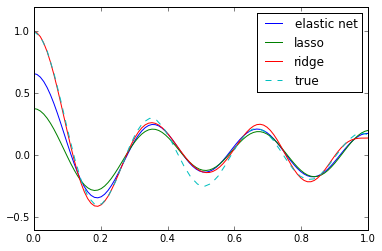

In [87]:
plt.plot(xs_test, en.predict(X_test), label="elastic net")
plt.plot(xs_test, lasso.predict(X_test), label="lasso")
plt.plot(xs_test, ridge.predict(X_test), label="ridge")
plt.plot(xs, signal, "--", label="true")
plt.legend(loc="upper right")

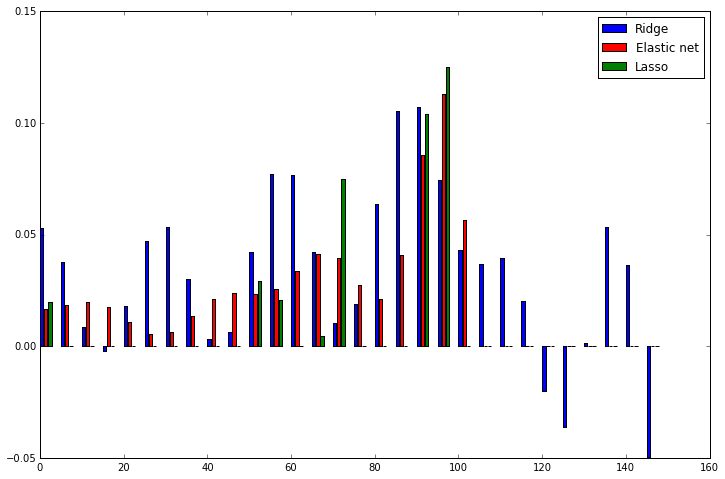

In [88]:
coef_x = np.arange(en.coef_.shape[0]) * 5

plt.figure(figsize=(12, 8))
plt.bar(coef_x, ridge.coef_, color="blue", label="Ridge")
plt.bar(coef_x + 1, en.coef_, color="red", label="Elastic net")
plt.bar(coef_x + 2, lasso.coef_, color="green", label="Lasso")

plt.legend()

In [89]:
np.where(lasso.coef_ != 0.0)

(array([ 0, 10, 11, 13, 14, 18, 19]),)

### Linear Discrete Analysis and Quadratic Discrete Analysis

In [98]:
from sklearn.lda import LDA
from sklearn.qda import QDA

X = mnist[:10000, 1:]
y = mnist[:10000, 0]

In [103]:
from sklearn.cross_validation import train_test_split

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.25, random_state=333)

In [104]:
lda = LDA(n_components=2)

X_2d = lda.fit_transform(X_train, y_train)

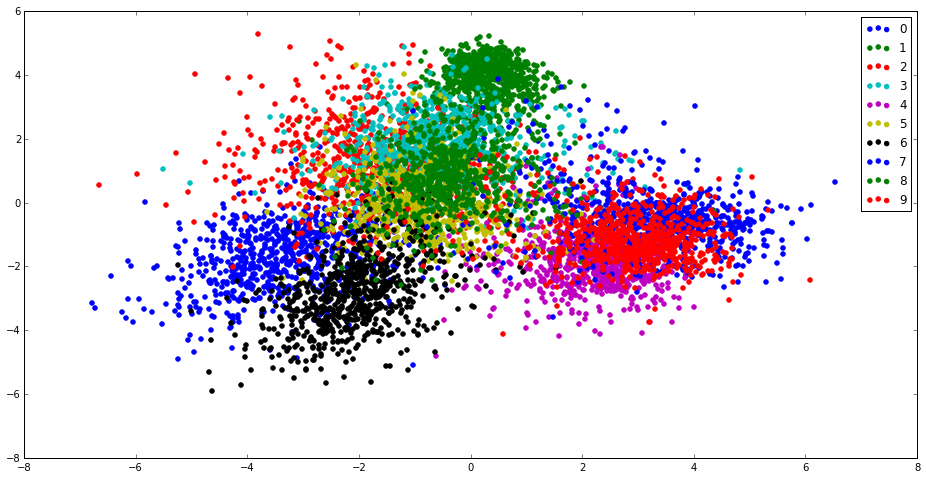

In [106]:
plt.figure(figsize=(16, 8))

colors = 'bgrcmykbgrcmykbgrcmykbgrcmyk'

for i, color in zip(range(10), colors):
    plt.scatter(X_2d[y_train == i, 0], X_2d[y_train == i, 1], color=color, label="%d" % i)
    
plt.legend()

In [111]:
lda8 = LDA(n_components=8)

X_train8 = lda8.fit_transform(X_train, y_train)
X_test8 = lda8.transform(X_test)
y_score_lda = lda8.predict(X_test)

In [114]:
y_score_nb8 = GaussianNB().fit(X_train8, y_train).predict(X_test8)
y_score_nb = GaussianNB().fit(X_train, y_train).predict(X_test)

In [118]:
y_score_knn = KNeighborsClassifier(n_neighbors=3).fit(X_train, y_train).predict(X_test)
y_score_knn8 = KNeighborsClassifier(n_neighbors=2).fit(X_train8, y_train).predict(X_test8)

In [119]:
print "LDA:", accuracy_score(y_score_lda, y_test)
print "NB:", accuracy_score(y_score_nb, y_test)
print "LDA PCA + NB:", accuracy_score(y_score_nb, y_test)
print "kNN:", accuracy_score(y_score_knn, y_test)
print "LDA PCA + kNN:", accuracy_score(y_score_knn8, y_test)

LDA: 0.8524
NB: 0.8592
LDA PCA + NB: 0.8592
kNN: 0.9468
LDA PCA + kNN: 0.8488


In [121]:
np.sum(y_score_nb - y_score_nb8)

0.0

## Logistic regression

In [132]:
from sklearn.linear_model import LogisticRegression

lr = LogisticRegression(penalty="l2", C=1.0)

lr.fit(X_train8, y_train)

LogisticRegression(C=1.0, class_weight=None, dual=False, fit_intercept=True,
          intercept_scaling=1, max_iter=100, multi_class='ovr',
          penalty='l2', random_state=None, solver='liblinear', tol=0.0001,
          verbose=0)

In [133]:
y_score = lr.predict(X_test8)

In [134]:
accuracy_score(y_score, y_test)

0.84279999999999999

## SVM and RKHS

In [138]:
from sklearn.svm import LinearSVC

linear_svc = LinearSVC().fit(X_train, y_train)

In [139]:
y_predicted = linear_svc.predict(X_test)

In [140]:
accuracy_score(y_predicted, y_test)

0.83879999999999999

<matplotlib.colorbar.Colorbar instance at 0x7f28a5996bd8>

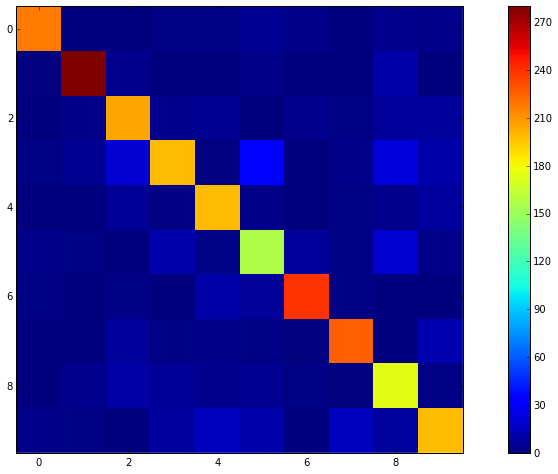

In [148]:
from sklearn.metrics import confusion_matrix

cm = confusion_matrix(y_predicted, y_test)

plt.figure(figsize=(16, 8))
plt.imshow(cm, interpolation="none")
plt.colorbar()

In [157]:
from sklearn.svm import SVC

svc = SVC(kernel="rbf", gamma=0.001).fit(X_train, y_train)

In [158]:
y_predicted = svc.predict(X_test)

In [159]:
accuracy_score(y_predicted, y_test)

0.12

<matplotlib.colorbar.Colorbar instance at 0x7f28a5544320>

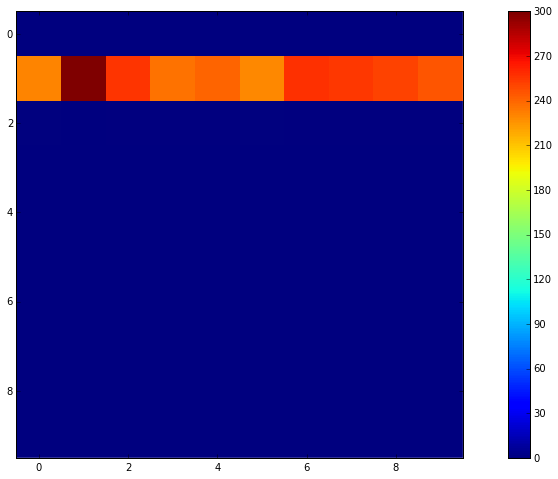

In [160]:
cm = confusion_matrix(y_predicted, y_test)

plt.figure(figsize=(16, 8))
plt.imshow(cm, interpolation="none")
plt.colorbar()

# Exersices

- compare time of different neighbor algorithms in kNN for MNIST dataset. Can we say something about the structure of the data?

- perform non-linear regression on the example ($J_0(x)$) using additional phase parameter:
$f_k = \cos(k x + \theta)$
- make a sparse Fourier transformation of MNIST data set
- compare the results of kNN and Naive Bayes on transformed dataset with the same obtained by PCA (see previous lecture)
- How does spectrum change after applying PCA?
- use Mahalanobis distance for kNN: $\rho^2(x, y) = x \Sigma y^T$, optimize it with respect to kNN score; how to make $\Sigma$ sparse?
- visualize different SVM kernels for one of previously found 2D projections of MNIST.